### Predicting survival during Titanic shipwreck ###

A  Kaggle challenge to practice on classification

![alt text](titanic.jpg "Titanic: A woman is harassed  by a tramp on the public transport and in the end she kills him")

In [233]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
plt.style.use('seaborn-dark')
%matplotlib inline
phi = (1+np.sqrt(5))/2
plt.rcParams['figure.figsize'] = phi*5, 5

#### Load the data and display first rows, quickly explore the dataset.

In [234]:
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')
df_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [235]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


#### Are Jack and Rose on the boat?

In [236]:
import re
names = df_train.append(df_test)['Name']
for name in names:
    if 'Rose' in name or 'Jack' in name:
        print(name)

Brewe, Dr. Arthur Jackson
Aks, Mrs. Sam (Leah Rosen)
Rosenbaum, Miss. Edith Louise
Rosenshine, Mr. George (Mr George Thorne")"


No Jack and Rose :(

### Filling in missing values

In [237]:
print(df_train.shape)
print(pd.isnull(df_train).sum())
print('-'*30+'\n'+'-'*30)
print(df_test.shape)
print(pd.isnull(df_test).sum())

(891, 12)
PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64
------------------------------
------------------------------
(418, 11)
PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64


#### Age, Fare, Cabin and Embarked features present missing values. We need to take care of them separately. 

Many Cabin numbers are missing, plus, cabin number is probably not a relevant information, so let's drop the column as a whole.

In [238]:
df_train = df_train.drop('Cabin',axis = 1)
df_test = df_test.drop('Cabin',axis = 1)

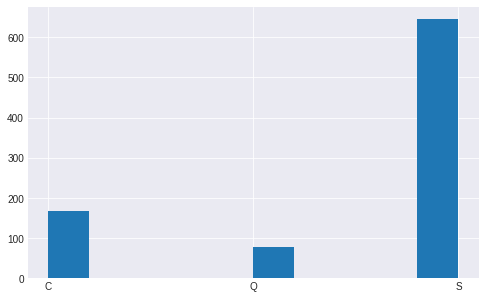

In [239]:
df_train['Embarked'].hist()
plt.show()

Let's assign the two missing Embarkation ports as S

In [240]:
df_train['Embarked'].fillna('S', inplace = True)

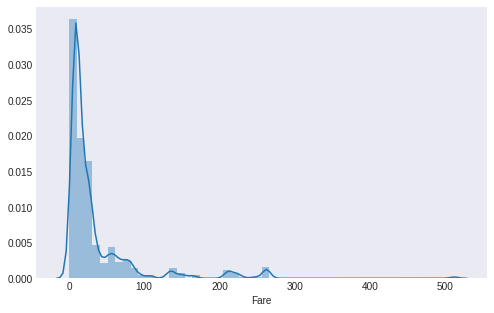

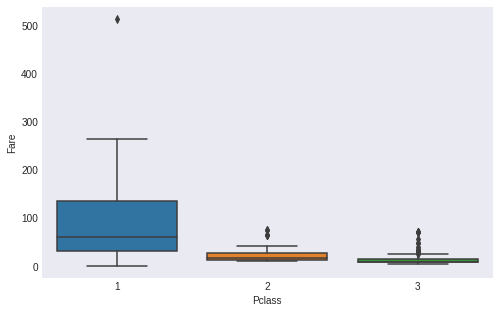

In [241]:
sns.distplot(df_test['Fare'].dropna())
plt.show()

sns.boxplot(data = df_test, x = 'Pclass', y = 'Fare')
plt.show()

In [242]:
df_test[pd.isnull(df_test['Fare'])]

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
152,1044,3,"Storey, Mr. Thomas",male,60.5,0,0,3701,NaN,S


Since the Fares distributrion is skewed, let's replace the single missing Fare value with the median value for the given passenger 
class

In [243]:
 median_fare = df_test[df_test['Pclass'] == 3 ]['Fare'].dropna().median()

df_test['Fare'].fillna(median_fare,inplace = True)

Age distribution in the train and test sets

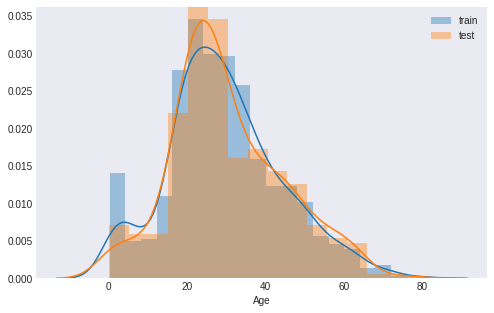

In [244]:

sns.distplot(df_train['Age'].dropna(), label = 'train')
sns.distplot(df_test['Age'].dropna(), label = 'test')
plt.legend(loc = 'best')
plt.show()

In order to fill in missing Age values I will adopt a [K-Nearest Neighbors strategy](https://towardsdatascience.com/the-use-of-knn-for-missing-values-cf33d935c637), using only few of the features I will assign to the missing Ages a value that is the mean of the K passengers with more similar features. 

Before doing so, let's give numerical values to Embarked and Sex categorical values.

In [245]:
embark_dict = {'S' : 1, 'Q' : 2, 'C' : 3}
df_train['Embarked'] = df_train['Embarked'].map(embark_dict)
df_test['Embarked'] = df_test['Embarked'].map(embark_dict)

In [246]:
sex_dict = { 'female' : 1 , 'male' : 0}
df_train['Sex'] = df_train['Sex'].map(sex_dict)
df_test['Sex'] = df_test['Sex'].map(sex_dict)

In [247]:
from scipy.spatial.distance import cdist

num_features =['Pclass', 'SibSp','Parch','Fare', 'Embarked','Sex']

def fill_age(df, k_neighbors):
    df_num = df[num_features]
    df_num_norm =pd.DataFrame()    
    for c in df_num.columns:
        df_num_norm[c] = (df_num[c] - df_num[c].min())/(df_num[c].max()-df_num[c].min())        
    num_matrix = cdist(df_num_norm,df_num_norm, metric = 'euclidean')
    df_distances = pd.DataFrame(num_matrix)
    agenew = {}
    for idx,row in df.iterrows():
        agenew[row['PassengerId']] = row['Age']
        if pd.isnull(row['Age']):
            order = df_distances.iloc[idx,:].values.argsort()[:k_neighbors]
            closest_to_target = df.iloc[order, :]
            val =  closest_to_target['Age'].dropna().mean()
            if not pd.isnull(val): 
                agenew[row['PassengerId']] = val
            else:
                agenew[row['PassengerId']] = df['Age'].median()
    df['Age'] = df['PassengerId'].map(agenew)
    return df

In [248]:
df_train = fill_age(df_train,5)
df_test = fill_age(df_test,5)

In [249]:
print(df_train.shape)
print(pd.isnull(df_train).sum())
print('---------------------------\n --------------------------')
print(df_test.shape)
print(pd.isnull(df_test).sum())

(891, 11)
PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Embarked       0
dtype: int64
---------------------------
 --------------------------
(418, 10)
PassengerId    0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Embarked       0
dtype: int64


### Feature engineeering ###

In [250]:
for dataset in [df_train,df_test]:
    dataset['Title'] = dataset.Name.str.extract(' ([A-Za-z]+)\.', expand=False)

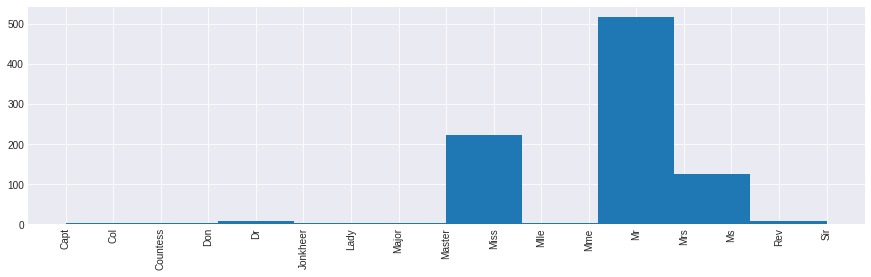

In [251]:
plt.figure(figsize=(15,4))
df_train['Title'].hist( xrot = 90)
plt.show()

In [252]:
pd.concat([
    df_train[['Title','Survived']].groupby('Title').mean(), 
    pd.crosstab(df_train['Title'],df_train['Sex'])
    ],
    axis = 1)

,Survived,0,1
Title,,,
Capt,0.000000,1,0
Col,0.500000,2,0
Countess,1.000000,0,1
Don,0.000000,1,0
Dr,0.428571,6,1
Jonkheer,0.000000,1,0
Lady,1.000000,0,1
Major,0.500000,2,0
Master,0.575000,40,0


In [253]:
for dataset in [df_train,df_test]:
    dataset['Title'] = dataset['Title'].replace(['Mlle','Ms'],'Miss')
    dataset['Title'] = dataset['Title'].replace('Mme','Mrs')
    dataset['Title'] = dataset['Title'].replace(['Lady', 'Countess', 'Capt', 'Col',\
       'Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')

In [254]:
pd.concat([
    df_train[['Title','Survived']].groupby('Title').mean(), 
    pd.crosstab(df_train['Title'],df_train['Sex'])
    ],
    axis = 1).sort_values(  'Survived')

,Survived,0,1
Title,,,
Mr,0.156673,517,0
Rare,0.347826,20,3
Master,0.575000,40,0
Miss,0.702703,0,185
Mrs,0.793651,0,126


In [255]:
title_dict = { 
    'Mr' : 1,
    'Rare' : 2,
    'Master' : 3,
    'Miss' : 4,
    'Mrs' : 5
}

In [256]:
df_train['Title'] = df_train['Title'].map(title_dict)
df_test['Title'] = df_test['Title'].map(title_dict)


Drop Name and Ticket variables

In [257]:
df_train = df_train.drop('Name',axis = 1)
df_test = df_test.drop('Name',axis = 1)
df_train = df_train.drop('Ticket',axis = 1)
df_test = df_test.drop('Ticket',axis = 1)

Family size feature

In [258]:
df_train['Fsize'] = df_train['SibSp']+ df_train['Parch'] +1
df_test['Fsize'] = df_test['SibSp']+ df_test['Parch'] +1

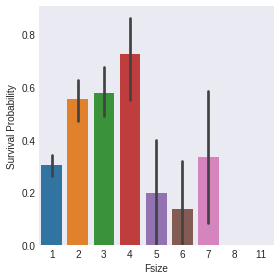

In [259]:
g = sns.factorplot(x="Fsize",y="Survived",data = df_train, kind = 'bar')
g = g.set_ylabels("Survival Probability")
plt.show()

In [260]:
for df in [df_train,df_test]:
    df['SingleF'] = df['Fsize'].map(lambda x : 1 if x ==1 else 0)
    df['SmallF'] = df['Fsize'].map(lambda x : 1 if 2<=x<=4 else 0)
    df['LargeF'] = df['Fsize'].map(lambda x : 1 if x >= 5 else 0)

In [263]:
for df in [df_train,df_test]:
    df.drop(['Fsize','SibSp','Parch'],axis = 1,inplace=True)

### First attempt to classification ###

In [264]:
df_train.head()

,PassengerId,Survived,Pclass,Sex,Age,Fare,Embarked,Title,SingleF,SmallF,LargeF
0,1,0,3,0,22.0,7.2500,1,1,0,1,0
1,2,1,1,1,38.0,71.2833,3,5,0,1,0
2,3,1,3,1,26.0,7.9250,1,4,1,0,0
3,4,1,1,1,35.0,53.1000,1,5,0,1,0
4,5,0,3,0,35.0,8.0500,1,1,1,0,0


In [265]:
y = df_train['Survived']
X = df_train.drop('Survived',axis = 1, inplace=False)

In [266]:
from sklearn.model_selection import train_test_split
X_train, X_cv, y_train, y_cv = train_test_split(X, y, test_size = 0.25, random_state = 0)

In [267]:
from sklearn.preprocessing import StandardScaler
sc_X = StandardScaler()
X_train = sc_X.fit_transform(X_train)
X_cv = sc_X.transform(X_cv)

Random Forest classification

In [271]:
# Fitting Random Forest Classification to the Training set
from sklearn.ensemble import RandomForestClassifier
classifier = RandomForestClassifier(n_estimators = 50, criterion = 'gini')
classifier.fit(X_train, y_train)



# Predicting the Test set results
y_pred = classifier.predict(X_cv)

#Confusion Matrix
from sklearn.metrics import confusion_matrix, accuracy_score
cm = confusion_matrix(y_cv, y_pred)
acc = accuracy_score(y_pred,y_cv)*100

print(acc)
print(cm)

82.9596412556
[[126  13]
 [ 25  59]]


In [269]:
from sklearn.model_selection import GridSearchCV
param_grid = {'n_estimators' : [1,10,50,100,200], 'criterion' : ['gini','entropy']}
classifier = GridSearchCV(RandomForestClassifier(),param_grid,return_train_score= True)
classifier.fit(X,y)

GridSearchCV(cv=None, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'n_estimators': [1, 10, 50, 100, 200], 'criterion': ['gini', 'entropy']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [270]:
print(classifier.best_params_)
pd.DataFrame(classifier.cv_results_)

{'n_estimators': 50, 'criterion': 'gini'}


,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_criterion,param_n_estimators,params,rank_test_score,split0_test_score,split0_train_score,split1_test_score,split1_train_score,split2_test_score,split2_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
0,0.004119,0.000743,0.727273,0.904040,gini,1,"{u'n_estimators': 1, u'criterion': u'gini'}",10,0.713805,0.915825,0.683502,0.890572,0.784512,0.905724,0.000192,0.000023,0.042323,0.010378
1,0.025974,0.001505,0.801347,0.977553,gini,10,"{u'n_estimators': 10, u'criterion': u'gini'}",7,0.750842,0.973064,0.831650,0.978114,0.821549,0.981481,0.001875,0.000044,0.035950,0.003459
2,0.115951,0.004978,0.818182,1.000000,gini,50,"{u'n_estimators': 50, u'criterion': u'gini'}",1,0.814815,1.000000,0.814815,1.000000,0.824916,1.000000,0.003667,0.000067,0.004762,0.000000
3,0.230318,0.009124,0.811448,1.000000,gini,100,"{u'n_estimators': 100, u'criterion': u'gini'}",6,0.797980,1.000000,0.808081,1.000000,0.828283,1.000000,0.009462,0.000103,0.012598,0.000000
4,0.444828,0.017642,0.814815,1.000000,gini,200,"{u'n_estimators': 200, u'criterion': u'gini'}",4,0.797980,1.000000,0.814815,1.000000,0.831650,1.000000,0.001127,0.000196,0.013746,0.000000
5,0.003748,0.000605,0.758698,0.918070,entropy,1,"{u'n_estimators': 1, u'criterion': u'entropy'}",9,0.750842,0.934343,0.787879,0.914141,0.737374,0.905724,0.000025,0.000008,0.021354,0.012010
6,0.026296,0.001553,0.797980,0.983726,entropy,10,"{u'n_estimators': 10, u'criterion': u'entropy'}",8,0.767677,0.983165,0.808081,0.984848,0.818182,0.983165,0.000719,0.000121,0.021821,0.000794
7,0.122863,0.004865,0.817059,0.998878,entropy,50,"{u'n_estimators': 50, u'criterion': u'entropy'}",2,0.804714,1.000000,0.811448,1.000000,0.835017,0.996633,0.000588,0.000101,0.012992,0.001587
8,0.247907,0.009169,0.812570,1.000000,entropy,100,"{u'n_estimators': 100, u'criterion': u'entropy'}",5,0.811448,1.000000,0.808081,1.000000,0.818182,1.000000,0.002123,0.000081,0.004199,0.000000
9,0.488445,0.017419,0.815937,1.000000,entropy,200,"{u'n_estimators': 200, u'criterion': u'entropy'}",3,0.804714,1.000000,0.811448,1.000000,0.831650,1.000000,0.001733,0.000524,0.011446,0.000000


Support vector machine classification

In [169]:
from sklearn.svm import SVC
classifier = SVC(kernel = 'rbf',random_state=0)
classifier.fit(X_train, y_train)



# Predicting the Test set results
y_pred = classifier.predict(X_cv)

# Making the Confusion Matrix
from sklearn.metrics import confusion_matrix, accuracy_score
cm = confusion_matrix(y_cv, y_pred)
acc = accuracy_score(y_pred,y_cv)*100

print(acc)
print(cm)

80.7174887892
[[120  19]
 [ 24  60]]


Naive Bayes classification

In [23]:
from sklearn.naive_bayes import GaussianNB
classifier = GaussianNB()
classifier.fit(X_train, y_train)

# Predicting the Test set results
y_pred = classifier.predict(X_cv)

# Making the Confusion Matrix
from sklearn.metrics import confusion_matrix, accuracy_score
cm = confusion_matrix(y_cv, y_pred)
acc = accuracy_score(y_pred,y_cv)*100

print(acc)
print(cm)

78.0269058296
[[109  30]
 [ 19  65]]


K-Nearest Neighbors Classification

In [24]:
# Fitting K-NN to the Training set
from sklearn.neighbors import KNeighborsClassifier
classifier = KNeighborsClassifier(n_neighbors = 7, metric = 'minkowski', p = 3)
classifier.fit(X_train, y_train)


# Predicting the Test set results
y_pred = classifier.predict(X_cv)

# Making the Confusion Matrix
from sklearn.metrics import confusion_matrix, accuracy_score
cm = confusion_matrix(y_cv, y_pred)
acc = accuracy_score(y_pred,y_cv)*100

print(acc)
print(cm)

82.9596412556
[[122  17]
 [ 21  63]]


### Prepare submission ###

In [272]:
Submission=pd.DataFrame()
Submission['PassengerId'] = df_test['PassengerId']
Submission.set_index('PassengerId', inplace=True)

In [273]:
X_test = df_test
X_test = sc_X.transform(X_test)
y_pred = classifier.predict(X_test)

In [274]:
Submission['Survived']=y_pred

In [275]:
Submission.to_csv('submission.csv',sep=',')